In [1]:
import os, sys
from scipy.ndimage import imread
from scipy.misc import imresize
import numpy
import pandas
import matplotlib.pyplot as plt
import keras
from IPython import display
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
def timed(f):
    """a decorator that prints the execution time of given function"""
    from time import time
    def time_decorator(*args, **kwargs):
        t = time()
        res = f(*args, **kwargs)
        print('Execution of "'+f.__name__+'()": {:.2f}s'.format(time()-t))
        return res
    return time_decorator

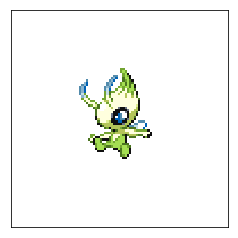

In [3]:
class Image:
    def __init__(self, data=None, path='img/251.png', reshape=None, normalize=True):
        if data != None:
            self.data = data
        else:
            self.data = imread(path)
        if reshape != None:
            self.data = imresize(self.data, reshape)
        if normalize:
            if self.data.dtype == 'uint8':
                self.data = self.data.astype('float32')/255.
        self.shape = self.data.shape
    def display(self, show=True):
        ax = plt.imshow(self.data)
        plt.xticks([])
        plt.yticks([])
        if show:
            plt.show()
        return ax
    
Image().display()

 10/10 images processed 
Execution of "__init__()": 0.03s


C:\Users\Timothee\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


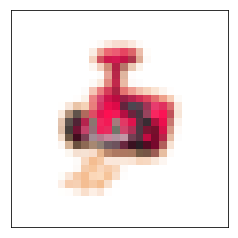

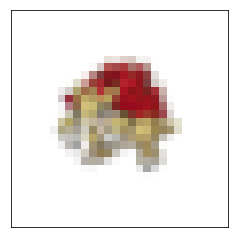

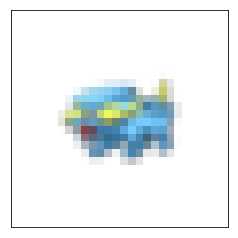

In [85]:
class Dataset:
    @timed
    def __init__(self, path="./img/", shape=(96, 96, 4), limit=None, randomized=True):
        self.data = [0]
        self.data += shape
        self.data = numpy.empty(self.data, dtype='float32')
        self.shape = shape
        files = os.listdir(path)
        if limit != None:
            if randomized:
                files = numpy.random.choice(files, limit)
            else:
                files = files[:limit]
        self.length = len(files)
        for file in files:
            self.data = numpy.concatenate([self.data, [Image(path="./img/"+file, reshape=shape).data]], axis=0)
            sys.stdout.write("\r {}/{} images processed".format(self.data.shape[0], self.length))
            sys.stdout.flush()
        print(' ')
    def display(self, limit=10, randomized=True):
        if randomized:
            for ix in numpy.random.choice(self.length, limit):
                Image(self.data[ix]).display()
    def sample(self, n=10):
        res = [n]
        res += self.shape
        res = numpy.empty(res)
        i = 0
        for ix in numpy.random.choice(self.length, n):
            res[i] = self.data[ix]
            i+=1
        return res

Dataset(shape=(28, 28, 4), limit=10).display(limit=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 39200)             3959200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 39200)             156800    
_________________________________________________________________
activation_1 (Activation)    (None, 39200)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 200)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 100)       180100    
__________

C:\Users\Timothee\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


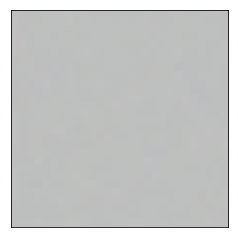

In [5]:
class Generator:
    def __init__(self, file=None, verbose=False):
        self.optimizer = keras.optimizers.Adam(lr=1e-3)
        nch = 200
        self.input = keras.models.Input(shape=[100])
        H = keras.layers.Dense(nch*14*14, kernel_initializer='glorot_normal')(self.input)
        H = keras.layers.BatchNormalization()(H)
        H = keras.layers.Activation('relu')(H)
        H = keras.layers.Reshape( [14, 14, nch] )(H)
        H = keras.layers.UpSampling2D(size=(2, 2))(H)
        H = keras.layers.Conv2D(int(nch/2), (3, 3), padding='same', kernel_initializer='glorot_uniform')(H)
        H = keras.layers.BatchNormalization()(H)
        H = keras.layers.Activation('relu')(H)
        H = keras.layers.Conv2D(int(nch/4), (3, 3), padding='same', kernel_initializer='glorot_uniform')(H)
        H = keras.layers.BatchNormalization()(H)
        H = keras.layers.Activation('relu')(H)
        H = keras.layers.Conv2D(4, (1, 1), padding='same', kernel_initializer='glorot_uniform')(H)
        g_V = keras.layers.Activation('sigmoid')(H)
        self.generator = keras.models.Model(self.input,g_V)
        self.generator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        if file != None:
            self.generator = keras.models.load_model(file)
        self.layers = self.generator.layers
        if verbose:
            self.generator.summary()
    def save(self, file='generator.h5'):
        self.generator.save(file)
        print('Generator model saved to "{}"'.format(file))
    def generate_display(self):
        noise = numpy.random.rand(1, 100)
        Image(self.generator.predict(noise)[0]).display()
    def generate(self, n=10):
        noise = numpy.random.rand(n, 100)
        return self.generator.predict(noise)

Generator(verbose=True).generate_display()

In [21]:
class Discriminator:
    """given an image as input, returns [1, 0] if the image is real, and [0, 1] if the image has been generated """
    def __init__(self, file=None, shape=(28, 28, 4), verbose=False):
        dropout_rate = 0.25
        self.optimizer = keras.optimizers.Adam(lr=1e-4)
        self.input = keras.models.Input(shape=shape)
        H = keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding = 'same', activation='relu')(self.input)
        H = keras.layers.LeakyReLU(0.2)(H)
        H = keras.layers.Dropout(dropout_rate)(H)
        H = keras.layers.Conv2D(512, (5, 5), strides=(2, 2), padding = 'same', activation='relu')(H)
        H = keras.layers.LeakyReLU(0.2)(H)
        H = keras.layers.Dropout(dropout_rate)(H)
        H = keras.layers.Conv2D(2, (3, 3), padding = 'same', activation='relu')(H)
        H = keras.layers.Flatten()(H)
        d_V = keras.layers.Dense(2, activation='softmax')(H)
        self.discriminator = keras.models.Model(self.input, d_V)
        self.discriminator.compile(loss='categorical_crossentropy', optimizer=self.optimizer)
        if file != None:
            self.discriminator = keras.models.load_model(file)
        self.layers = self.discriminator.layers
        if verbose:
            self.discriminator.summary()
    def save(self, file='discriminator.h5'):
        self.discriminator.save(file)
        print('Discriminator model saved to "{}"'.format(file))
    def freeze_training(self, _to=False):
        self.discriminator.trainable = _to
        for l in self.layers:
            l.trainable = _to
    def unfreeze_training(self, _to=True):
        self.freeze_training(_to)
    def predict(self, x):
        return self.discriminator.predict(x)

Discriminator(verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 28, 28, 4)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 14, 256)       25856     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 7, 7, 512)         3277312   
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 7, 7, 512)         0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 7, 7, 512)         0         
__________

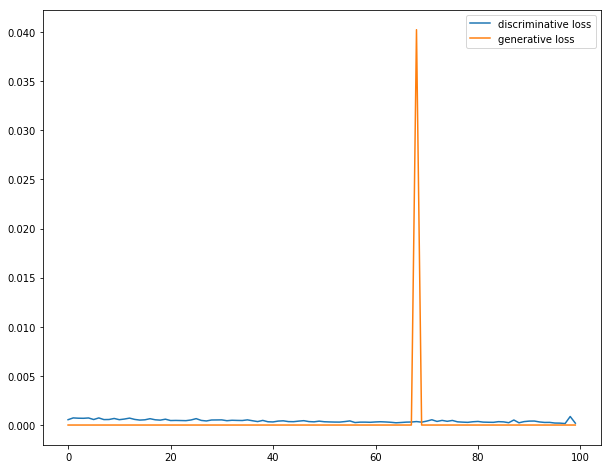

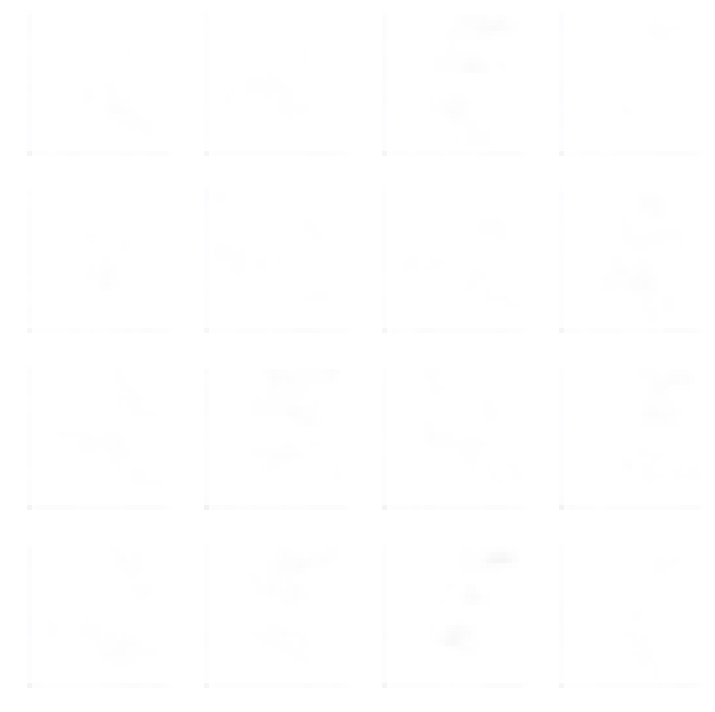

Mean label attributed by the Discriminator to Real Data: [1.0000, 0.0000]
Mean label attributed by the Discriminator to Generated Data: [0.0002, 0.9998]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:36<00:00,  2.03s/it]


In [28]:
class GAN:
    def __init__(self, shape=(28, 28, 4), dataset=None, generator=None, discriminator=None, pretrain=True, verbose=False):
        if dataset!=None:
            self.dataset = dataset
        else:
            self.dataset = Dataset(shape=shape)
        self.generator = Generator(file=generator)
        self.discriminator = Discriminator(file=discriminator, shape=shape)
        self.gan = keras.models.Model(self.generator.input, self.discriminator.discriminator(self.generator.generator(self.generator.input)))
        self.gan.compile(loss='categorical_crossentropy', optimizer=self.generator.optimizer)
        self.losses = {"d":[], "g":[]}
        if verbose:
            self.gan.summary()
        if pretrain:
            self.pretrain_discriminator()
            self.print_accuracy()
    def pretrain_discriminator(self, n_iter=100, sample=32):
        for i in tqdm(range(n_iter)):
            # Train discriminator on generated images
            x = numpy.concatenate([self.generator.generate(sample), self.dataset.sample(sample)], axis=0)
            y = numpy.concatenate([numpy.array([[0., 1.]]*(sample), dtype='float32'), numpy.array([[1, 0.]]*(sample), dtype='float32')], axis=0)
            self.discriminator.discriminator.train_on_batch(x, y)
    def train(self, n_iter=5000, sample=32, plt_freq=25):
        for i in tqdm(range(n_iter)):
            # Train discriminator on generated images
            for j in range(10):
                x = numpy.concatenate([self.generator.generate(sample), self.dataset.sample(sample)], axis=0)
                y = numpy.concatenate([numpy.array([[0., 1.]]*(sample), dtype='float32'), numpy.array([[1, 0.]]*(sample), dtype='float32')], axis=0)
                d_loss  = self.discriminator.discriminator.train_on_batch(x, y)
            self.losses["d"].append(d_loss)
            if d_loss > 1:
                print("Retraining Discriminator")
                self.pretrain_discriminator()
            # train Generator-Discriminator stack on input noise to non-generated output class
            self.discriminator.freeze_training()
            x = numpy.random.rand(sample, 100)
            y = numpy.array([[1., 0.]]*(sample), dtype='float32')
            g_loss = self.gan.train_on_batch(x, y)
            self.losses["g"].append(g_loss)
            self.discriminator.unfreeze_training()
            # Updates plots
            if i%plt_freq==plt_freq-1:
                self.plot_loss()
                self.plot_gen()
                self.print_accuracy()
        return self
    def save(self, generator='generator.h5', discriminator='discriminator.h5'):
        self.generator.save(generator)
        self.discriminator.save(discriminator)
    def generate_display(self):
        self.generator.generate_display()
    def plot_loss(self):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(self.losses["d"][-100:], label='discriminative loss')
        plt.plot(self.losses["g"][-100:], label='generative loss')
        plt.legend()
        plt.show()
    def plot_gen(self, n_ex=16,dim=(4,4), figsize=(10,10)):
        generated_images = self.generator.generate(n_ex)
        plt.figure(figsize=figsize)
        for i in range(n_ex):
            plt.subplot(dim[0],dim[1],i+1)
            plt.imshow(generated_images[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    def print_accuracy(self):
        d_real = self.discriminator.predict(self.dataset.sample(100)).mean(axis=0)
        print("Mean label attributed by the Discriminator to Real Data: [{:.4f}, {:.4f}]".format(d_real[0], d_real[1]))
        d_gen = self.discriminator.predict(self.generator.generate(100)).mean(axis=0)
        print("Mean label attributed by the Discriminator to Generated Data: [{:.4f}, {:.4f}]".format(d_gen[0], d_gen[1]))
        return self

gan = GAN(verbose=True).train(200)

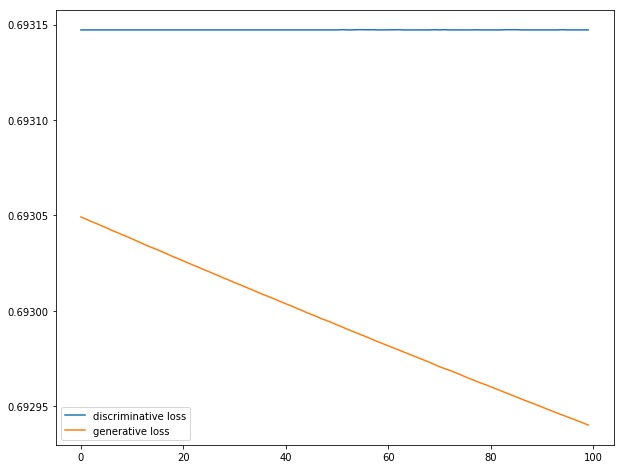

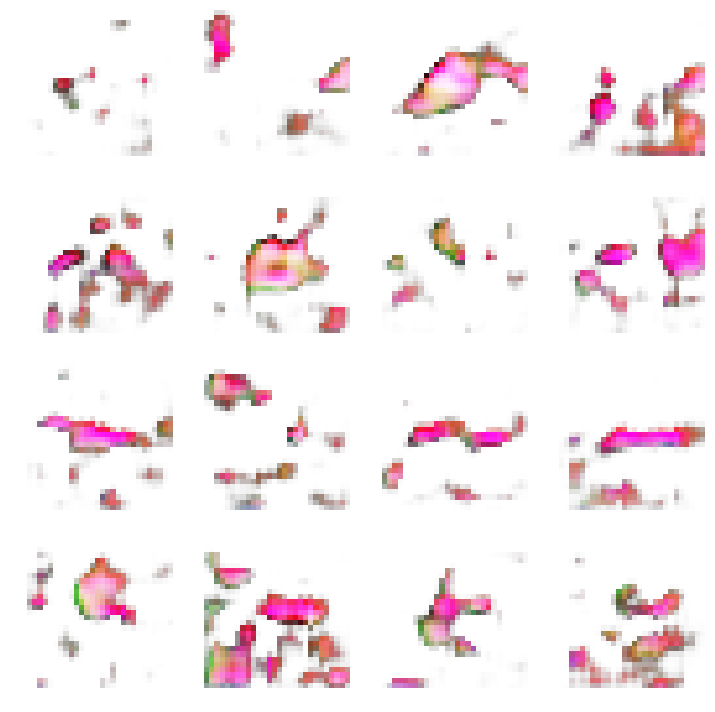

Mean label attributed by the Discriminator to Real Data: [0.5006, 0.4994]
Mean label attributed by the Discriminator to Generated Data: [0.5006, 0.4994]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:33<00:00,  2.04s/it]


In [58]:
gan.train(200)

In [56]:
for i in range(5):
    gan.pretrain_discriminator(1000)
    gan.print_accuracy()
    gan.train(200)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:20<00:00,  6.53it/s]


Mean label attributed by the Discriminator to Real Data: [0.5000, 0.5000]
Mean label attributed by the Discriminator to Generated Data: [0.5000, 0.5000]


In [86]:
gan.save('generator3.h5', 'discriminator3.h5')
gan.gan.save('gan.h5')

Discriminator model saved to "generator3.h5"
Discriminator model saved to "discriminator3.h5"


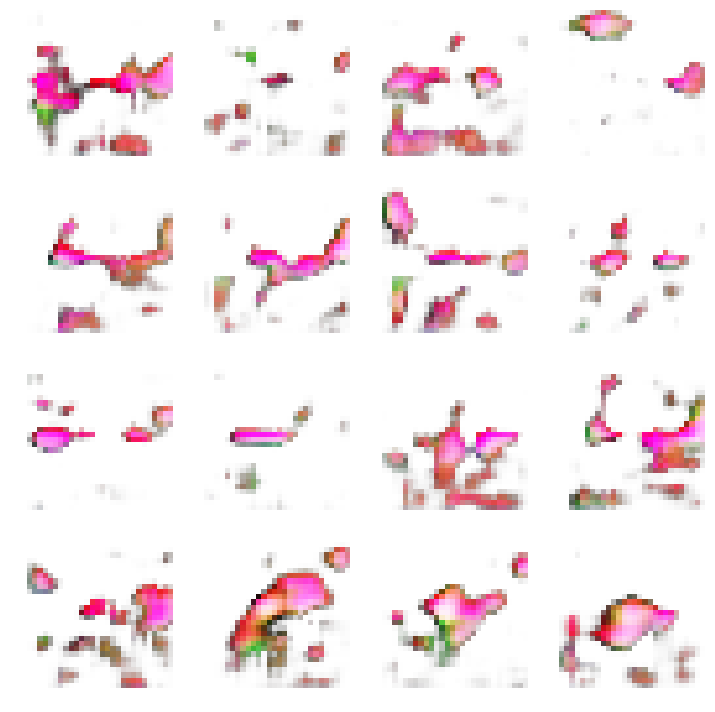

In [79]:
gan.plot_gen()